In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv('/content/drive/MyDrive/city_day.csv')
df.head()

,City,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket
0,Ahmedabad,2015-01-01,NaN,NaN,0.92,18.22,17.15,NaN,0.92,27.64,133.36,0.00,0.02,0.00,NaN,NaN
1,Ahmedabad,2015-01-02,NaN,NaN,0.97,15.69,16.46,NaN,0.97,24.55,34.06,3.68,5.50,3.77,NaN,NaN
2,Ahmedabad,2015-01-03,NaN,NaN,17.40,19.30,29.70,NaN,17.40,29.07,30.70,6.80,16.40,2.25,NaN,NaN
3,Ahmedabad,2015-01-04,NaN,NaN,1.70,18.48,17.97,NaN,1.70,18.59,36.08,4.43,10.14,1.00,NaN,NaN
4,Ahmedabad,2015-01-05,NaN,NaN,22.10,21.42,37.76,NaN,22.10,39.33,39.31,7.01,18.89,2.78,NaN,NaN


In [ ]:
# Calculate the percentage of missing values for each column
missing_percentage = df.isnull().sum() * 100 / len(df)
print('Missing Percentage:', missing_percentage)

Missing Percentage: City           0.000000
Date           0.000000
PM2.5         11.109211
PM10          34.670316
NO             9.509963
NO2            8.629094
NOx           10.005986
NH3           26.922090
CO             8.381083
SO2           10.519114
O3            11.596682
Benzene       15.256991
Toluene       20.200120
Xylene        64.072522
AQI           11.972975
AQI_Bucket    11.972975
dtype: float64


In [ ]:
# Mean/Median Imputation for Numerical Columns
numerical_cols = ['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3', 'Benzene', 'Toluene', 'Xylene', 'AQI']
for col in numerical_cols:
    df[col].fillna(df[col].mean(), inplace=True)

In [ ]:
import numpy as np
# Create a mapping based on existing data
aqi_bucket_mapping = {
    'Good': (0, 50),
    'Satisfactory': (51, 100),
    'Moderate': (101, 200),
    'Poor': (201, 300),
    'Very Poor': (301, 400),
    'Severe': (401, 500)
}
def map_aqi_to_bucket(aqi_value):
    for bucket, (lower, upper) in aqi_bucket_mapping.items():
        if lower <= aqi_value <= upper:
            return bucket
    return np.nan  # return NaN if the AQI value is out of known ranges
# Apply the mapping function to fill 'AQI_Bucket'
df['AQI_Bucket'].fillna(df['AQI'].apply(map_aqi_to_bucket), inplace=True)

In [ ]:
# Calculate the percentage of missing values for each column after cleaning
missing_percentage_after = df.isnull().sum() * 100 / len(df)
print('Missing Percentage After Cleaning:', missing_percentage_after)


Missing Percentage After Cleaning: City          0.0
Date          0.0
PM2.5         0.0
PM10          0.0
NO            0.0
NO2           0.0
NOx           0.0
NH3           0.0
CO            0.0
SO2           0.0
O3            0.0
Benzene       0.0
Toluene       0.0
Xylene        0.0
AQI           0.0
AQI_Bucket    0.0
dtype: float64


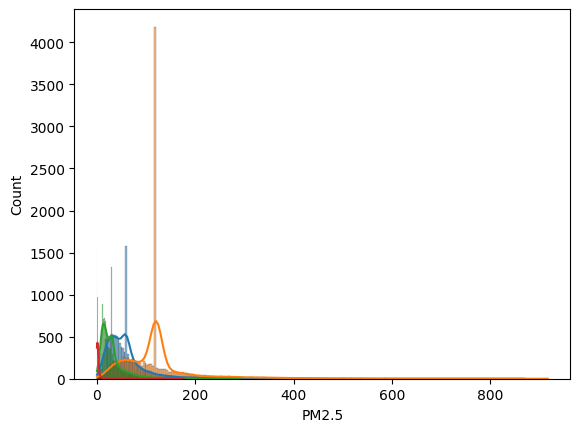

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.histplot(df['PM2.5'], kde=True)
sns.histplot(df['PM10'], kde=True)
sns.histplot(df['NO2'], kde=True)
sns.histplot(df['CO'], kde=True)
plt.show()

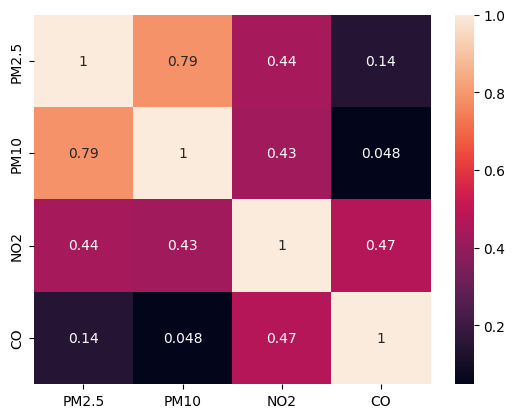

In [ ]:
correlation_matrix = df[['PM2.5', 'PM10', 'NO2', 'CO']].corr()
sns.heatmap(correlation_matrix, annot=True)
plt.show()

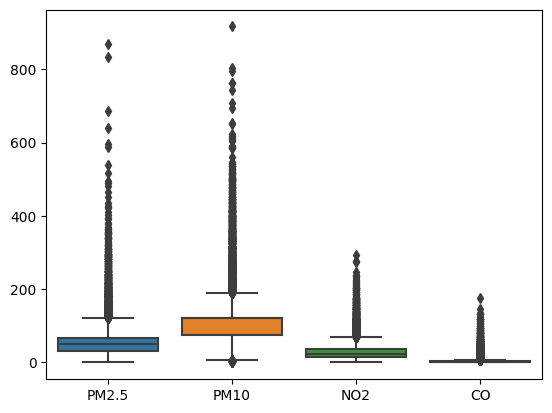

In [ ]:
sns.boxplot(data=df[['PM2.5', 'PM10', 'NO2', 'CO']])
plt.show()

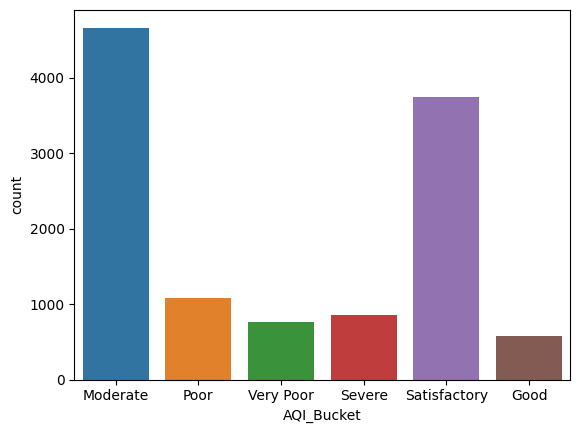

In [ ]:
sns.countplot(data=df, x='AQI_Bucket')
plt.show()

<ipython-input-11-f498a321ff5f>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True, cmap='coolwarm')


<Axes: >

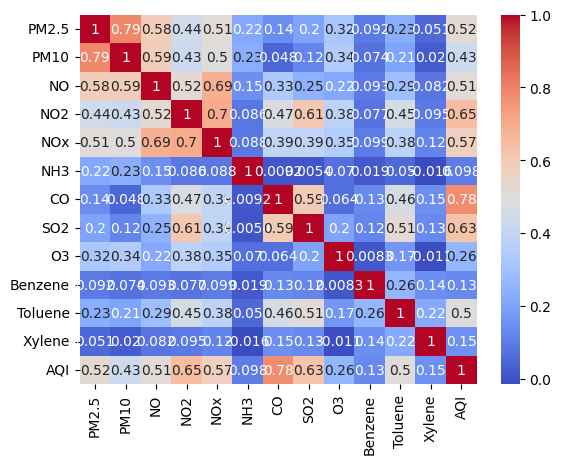

In [ ]:
# Create a heatmap to visualize the correlation between features and 'AQI_Bucket'
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')

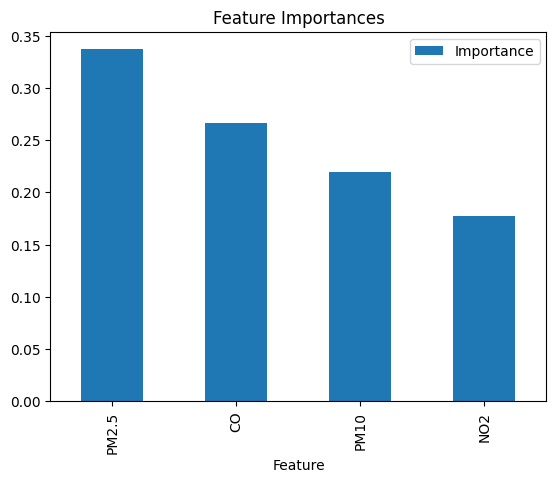

In [ ]:
# Function for calculating feature importances
def feature_importance(X_train, y_train):
    # Initialize the model
    rf = RandomForestClassifier()
    # Fit the model
    rf.fit(X_train, y_train)
    # Get feature importances
    importances = rf.feature_importances_
    # Create a DataFrame for visualization
    feature_importances = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})
    # Sort and visualize
    feature_importances.sort_values(by='Importance', ascending=False).plot(kind='bar', x='Feature', y='Importance')
    plt.title("Feature Importances")
    plt.show()

# Prepare the features and target variable
X = df[['PM2.5', 'PM10', 'NO2', 'CO']]
y = df['AQI_Bucket']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Call the feature importance function here
feature_importance(X_train, y_train)




In [ ]:
# Function for hyperparameter tuning
def tune_hyperparameters(model, param_grid, X, y):
    grid_search = GridSearchCV(model, param_grid, cv=5)
    grid_search.fit(X, y)
    return grid_search.best_params_

# Function for model evaluation
def evaluate_model(model, X_val, y_val, X_test, y_test):
    y_pred_val = model.predict(X_val)
    print("Validation Results:")
    print(classification_report(y_val, y_pred_val))

    y_pred_test = model.predict(X_test)
    print("Test Results:")
    print(classification_report(y_test, y_pred_test))

# Data Splitting
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Scaling
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Initialize models and their parameter grids
models_param_grid = {
    'LogisticRegression': (LogisticRegression(max_iter=1000), {'C': [0.001, 0.01, 0.1, 1, 10, 100]}),  # max_iter set to 1000 here
    'RandomForestClassifier': (RandomForestClassifier(random_state=42), {'n_estimators': [50, 100, 200], 'max_depth': [10, 20, 30], 'min_samples_split': [2, 5, 10]}),
    'SVC': (SVC(), {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf'], 'gamma': ['auto', 'scale']})
}

# Loop through models for training, tuning, and evaluation
for model_name, (model, param_grid) in models_param_grid.items():
    print(f"Training and evaluating {model_name}...")
    best_params = tune_hyperparameters(model, param_grid, X_train, y_train)

    # Train model with best parameters
    final_model = model.set_params(**best_params)
    final_model.fit(X_train, y_train)

    # Evaluate model
    evaluate_model(final_model, X_val, y_val, X_test, y_test)

# Benchmark model
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
y_pred_dummy = dummy_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_dummy)
print(f"Benchmark Model Accuracy: {accuracy}")

Training and evaluating LogisticRegression...
Validation Results:
              precision    recall  f1-score   support

        Good       0.89      0.20      0.33        85
    Moderate       0.75      0.80      0.78       728
        Poor       0.63      0.40      0.49       146
Satisfactory       0.71      0.82      0.76       541
      Severe       0.78      0.76      0.77       135
   Very Poor       0.67      0.66      0.66       119

    accuracy                           0.73      1754
   macro avg       0.74      0.60      0.63      1754
weighted avg       0.73      0.73      0.72      1754

Test Results:
              precision    recall  f1-score   support

        Good       0.84      0.17      0.29        93
    Moderate       0.73      0.81      0.76       704
        Poor       0.59      0.32      0.42       159
Satisfactory       0.71      0.83      0.77       566
      Severe       0.86      0.85      0.85       123
   Very Poor       0.72      0.57      0.64       10